In [1]:
'''A simple implementation of Daum's particle flow filter for the lorenz 63 equations.'''

from diffrax import diffeqsolve, ODETerm,ControlTerm
from jax.scipy.stats import norm
import diffrax
import jax.numpy as jnp
import numpy as np
import jax
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [2]:

t_vec = jnp.linspace(0,50,1000)

def lorenz_drift(t,X,args):

  x,y,z = X

  sigma,rho,beta,_ = args

  dX = sigma * (y - x)
  dY = x * (rho - z) - y
  dZ = x * y - beta * z


  return jnp.array([dX,dY,dZ])

def lorenz_diffusion(t,X,args):

  _,_,_,noise = args

  return noise * jnp.eye(len(X))

In [3]:
'''The model integrator. Takes the length of time to integrate, the initial condition,prng key, and a parameter vector.'''
def model(ts,y0,par,key):
  key,w_key = jax.random.split(key)
  brownian_motion = diffrax.VirtualBrownianTree(ts[0],ts[-1], tol=1e-3, shape=(len(y0),), key=w_key)
  terms = diffrax.MultiTerm(ODETerm(lorenz_drift), ControlTerm(lorenz_diffusion, brownian_motion))

  solution = diffrax.diffeqsolve(
            terms,
            diffrax.Heun(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=ts) #At which points to save the output
        )
  return solution.ys


noise = 10.
key = jax.random.key(0)
key,sim_key = jax.random.split(key)

'''Simulate model'''
X_true = model(t_vec,y0 = jnp.array([1.,1.,1.]),par = (10,28,8/3,noise),key = sim_key)

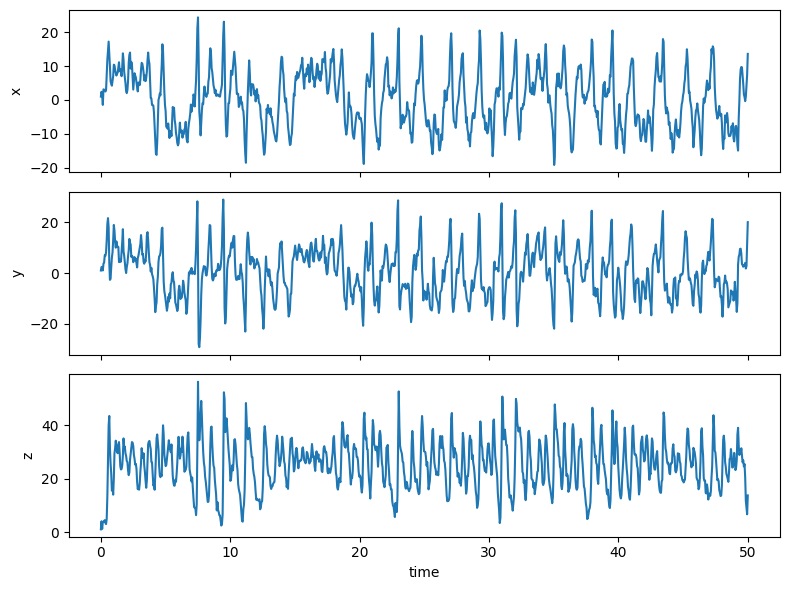

In [4]:
X = np.array(X_true)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].plot(t_vec, X[:, 0])
axes[0].set_ylabel("x")

axes[1].plot(t_vec, X[:, 1])
axes[1].set_ylabel("y")

axes[2].plot(t_vec, X[:, 2])
axes[2].set_ylabel("z")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.show()

In [5]:
'''Observations will be just the X values'''
H = jnp.array([[0.,1.,0.]])
OBS = X_true.T

OBS = H @ OBS


In [6]:
'''Now for the particle filter'''
num_particles = 5
key,init_key = jax.random.split(key)
delta_t = t_vec[1] - t_vec[0]
par_t_vec = jnp.linspace(0.,delta_t,10)
R_cov = (noise**2) * jnp.eye(1)

particles = jax.random.normal(key = init_key, shape = (num_particles,3))
weights = jnp.full((num_particles,),fill_value = 1/num_particles)

model_lam = lambda y0,key: model(par_t_vec,y0 = y0,par = (10,28,8/3,noise),key = key)

vmap_model_lam = jax.vmap(model_lam,in_axes = (0,0))

mean = jnp.zeros((len(t_vec),3))
for step,observation in enumerate(OBS.T): 
    if step > 0: 
        key,sim_key = jax.random.split(key)
        sim_keys = jax.random.split(sim_key,num_particles)
        particles = vmap_model_lam(particles,sim_keys)[:,-1,:]

    weights = jax.scipy.stats.multivariate_normal.pdf(x = observation,mean = (H @ particles.T).T,cov = R_cov)
    weights = weights/jnp.sum(weights)

    key,resample_key = jax.random.split(key)
    indices = jax.random.choice(resample_key,jnp.arange(num_particles),shape = (num_particles,),p = weights)

    particles = particles[indices,:]

    mean = mean.at[step].set(jnp.mean(particles,axis = 0))


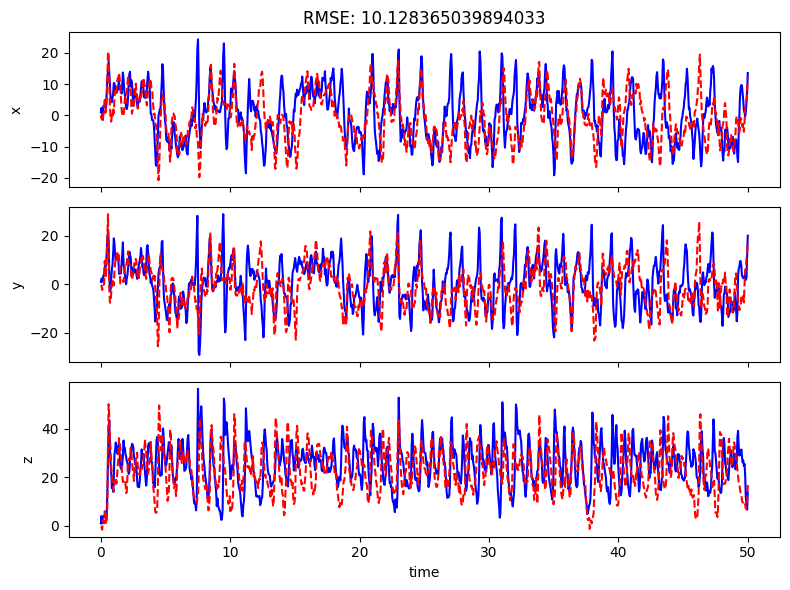

In [7]:
X = np.array(X_true)
PF_MEAN = np.array(mean)

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

rmse_pf = np.sqrt(mean_squared_error(X, PF_MEAN))

axes[0].set_title(f"RMSE: {rmse_pf}")
axes[0].plot(t_vec, X[:, 0],color = 'blue')
axes[0].plot(t_vec, PF_MEAN[:, 0],'--',color = 'red')
axes[0].set_ylabel("x")

axes[1].plot(t_vec, X[:, 1],color = 'blue')
axes[1].plot(t_vec, PF_MEAN[:, 1],'--',color = 'red')
axes[1].set_ylabel("y")

axes[2].plot(t_vec, X[:, 2],color = 'blue')
axes[2].plot(t_vec, PF_MEAN[:, 2],'--',color = 'red')
axes[2].set_ylabel("z")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.show()

In [8]:
'''Now for the Ensemble Kalman filter'''
num_ensemble_members = 5
key,init_key = jax.random.split(key)
delta_t = t_vec[1] - t_vec[0]
par_t_vec = jnp.linspace(0.,delta_t,10)
R_cov = (noise**2) * jnp.eye(1)

members = jax.random.normal(key = init_key, shape = (num_ensemble_members,3))

model_lam = lambda y0,key: model(par_t_vec,y0 = y0,par = (10,28,8/3,noise),key = key)
vmap_model_lam = jax.vmap(model_lam,in_axes = (0,0))

def kalman_update(member,key,obs,K): 
    eps = jax.random.multivariate_normal(key, mean = jnp.zeros(len(observation)),cov = R_cov)

    return member + K @ (obs - H@member + eps)

vmap_kalman_update = jax.vmap(kalman_update, in_axes = (0,0,None,None))

ens_mean = jnp.zeros((len(t_vec),3))
for step,observation in enumerate(OBS.T): 
    if step > 0: 
        key,sim_key = jax.random.split(key)
        sim_keys = jax.random.split(sim_key,num_ensemble_members)
        members = vmap_model_lam(members,sim_keys)[:,-1,:]

    m_prior = jnp.mean(members,axis = 0)
    cov_prior = jnp.cov(members.T)

    K = cov_prior @ H.T @ jnp.linalg.pinv(H @ cov_prior @ H.T + R_cov)

    key,eps_key = jax.random.split(key)
    eps_keys = jax.random.split(eps_key,num_ensemble_members)

    members = vmap_kalman_update(members,eps_keys,observation,K)

    ens_mean = ens_mean.at[step].set(jnp.mean(members,axis = 0))


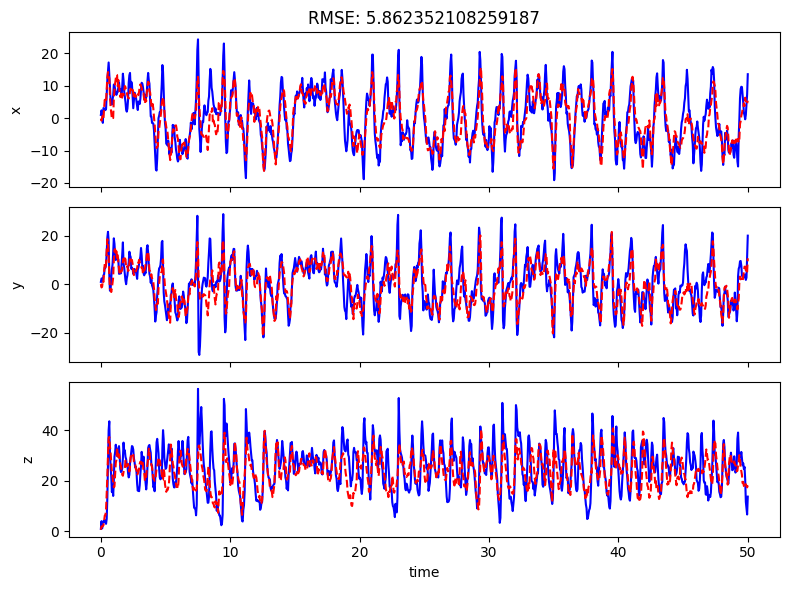

In [9]:
X = np.array(X_true)
ENKF_MEAN = np.array(ens_mean)

rmse_enkf = np.sqrt(mean_squared_error(X, ENKF_MEAN))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].set_title(f"RMSE: {rmse_enkf}")
axes[0].plot(t_vec, X[:, 0],color = 'blue')
axes[0].plot(t_vec, ENKF_MEAN[:, 0],'--',color = 'red')
axes[0].set_ylabel("x")

axes[1].plot(t_vec, X[:, 1],color = 'blue')
axes[1].plot(t_vec, ENKF_MEAN[:, 1],'--',color = 'red')
axes[1].set_ylabel("y")

axes[2].plot(t_vec, X[:, 2],color = 'blue')
axes[2].plot(t_vec, ENKF_MEAN[:, 2],'--',color = 'red')
axes[2].set_ylabel("z")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.show()

In [10]:
def f(t,x,args):
    P_inv,H,R_inv,obs = args

    dx = -jnp.linalg.pinv(P_inv + t * (H.T @ R_inv @ H)) @ H.T @ R_inv @ (H @ x - obs)

    return dx


In [11]:
def particle_dynamics(ts,y0,par):

  solution = diffrax.diffeqsolve(
            ODETerm(f),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            max_steps=5000,
            stepsize_controller=diffrax.PIDController(rtol = 1e-3,atol = 1e-3)
        )
  return solution.ys

In [12]:
'''Now for the particle flow filter'''
num_particles = 100
key,init_key = jax.random.split(key)
delta_t = t_vec[1] - t_vec[0]
par_t_vec = jnp.linspace(0.,delta_t,10)
R_cov = (noise**2) * jnp.eye(1)
R_inv = jnp.linalg.pinv(R_cov)

particles = jax.random.normal(key = init_key, shape = (num_particles,3))
lams = jnp.linspace(0.,1.,100)

model_lam = lambda y0,key: model(par_t_vec,y0 = y0,par = (10,28,8/3,noise),key = key)
vmap_model_lam = jax.vmap(model_lam,in_axes = (0,0))

vmap_dynamics = jax.vmap(particle_dynamics,in_axes = (None,0,None))

pff_mean = jnp.zeros((len(t_vec),3))
for step,observation in enumerate(OBS.T): 
    if step > 0: 
        key,sim_key = jax.random.split(key)
        sim_keys = jax.random.split(sim_key,num_particles)
        particles = vmap_model_lam(particles,sim_keys)[:,-1,:]

    P = jnp.cov(particles.T)
    x_pred = jnp.mean(particles,axis = 0)
    P_inv = jnp.linalg.inv(P)

    particles = vmap_dynamics(lams,particles,(P_inv,H,R_inv,observation))[:,-1,:]

    pff_mean = pff_mean.at[step].set(x_pred)


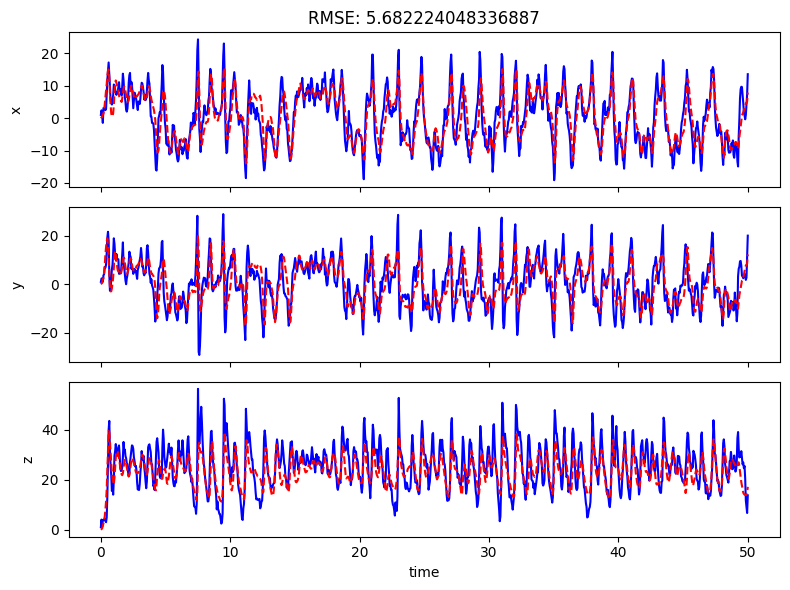

In [13]:
X = np.array(X_true)
PFF_MEAN = np.array(pff_mean)

rmse_pff = np.sqrt(mean_squared_error(X, PFF_MEAN))

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

axes[0].set_title(f"RMSE: {rmse_pff}")
axes[0].plot(t_vec, X[:, 0],color = 'blue')
axes[0].plot(t_vec, PFF_MEAN[:, 0],'--',color = 'red')
axes[0].set_ylabel("x")

axes[1].plot(t_vec, X[:, 1],color = 'blue')
axes[1].plot(t_vec, PFF_MEAN[:, 1],'--',color = 'red')
axes[1].set_ylabel("y")

axes[2].plot(t_vec, X[:, 2],color = 'blue')
axes[2].plot(t_vec, PFF_MEAN[:, 2],'--',color = 'red')
axes[2].set_ylabel("z")
axes[2].set_xlabel("time")

plt.tight_layout()
plt.show()